In [1]:
!cp drive/MyDrive/fraudetection.zip .
!unzip -q fraudetection.zip

replace fraudTest.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Loading and Preprocessing

In [3]:
def preprocess(df):
  transformed_df = df.copy()

  transformed_df['age'] = transformed_df['trans_date_trans_time'].dt.year - transformed_df['dob' ].dt.year
  transformed_df = transformed_df.drop(['dob', 'trans_date_trans_time'], axis=1)

  transformed_df['category'] = transformed_df['category'].cat.codes

  grouped = transformed_df.groupby(['cc_num'])

  grp_amt_feat = grouped.agg({
    'cc_num': 'count',
    'amt': ['sum', 'mean', 'median', 'std'],
  })

  grp_amt_feat.columns = ['_'.join(col).strip() for col in grp_amt_feat.columns.values]
  transformed_df = transformed_df.merge(grp_amt_feat, on='cc_num', how='left')


  return transformed_df


In [4]:
def load_and_preprocess(path):
  df = pd.read_csv(
      path,
      dtype={
          'gender': 'category',
          'category': 'category',
          'is_fraud': np.uint8,
          'lat': np.float32,
          'long': np.float32,
          'merch_lat': np.float32,
          'merch_long': np.float32,
          'merchant': 'category',
      },
      usecols=[
          'category',
          'is_fraud',
          'lat',
          'long',
          'merch_lat',
          'merch_long',
          'amt',
          'cc_num',
          'dob',
          'trans_date_trans_time',
      ],
      parse_dates=['dob', 'trans_date_trans_time']
    )

  return preprocess(df)

In [5]:
train_df = load_and_preprocess("fraudTrain.csv")
train_df.head()

,cc_num,category,amt,lat,long,merch_lat,merch_long,is_fraud,age,cc_num_count,amt_sum,amt_mean,amt_median,amt_std
0,2703186189652095,8,4.97,36.078800,-81.178101,36.011292,-82.048317,0,31,2028,177233.44,87.393215,53.885,126.596221
1,630423337322,4,107.23,48.887798,-118.210503,49.159046,-118.186462,0,41,3030,163466.44,53.949320,31.565,118.337621
2,38859492057661,0,220.11,42.180801,-112.262001,43.150703,-112.154480,0,57,503,33132.63,65.870040,47.530,101.585754
3,3534093764340240,2,45.00,46.230598,-112.113800,47.034332,-112.561073,0,52,493,35878.90,72.776673,36.830,148.593473
4,375534208663984,9,41.96,38.420700,-79.462898,38.674999,-78.632462,0,33,2017,191974.21,95.178091,75.690,89.133972


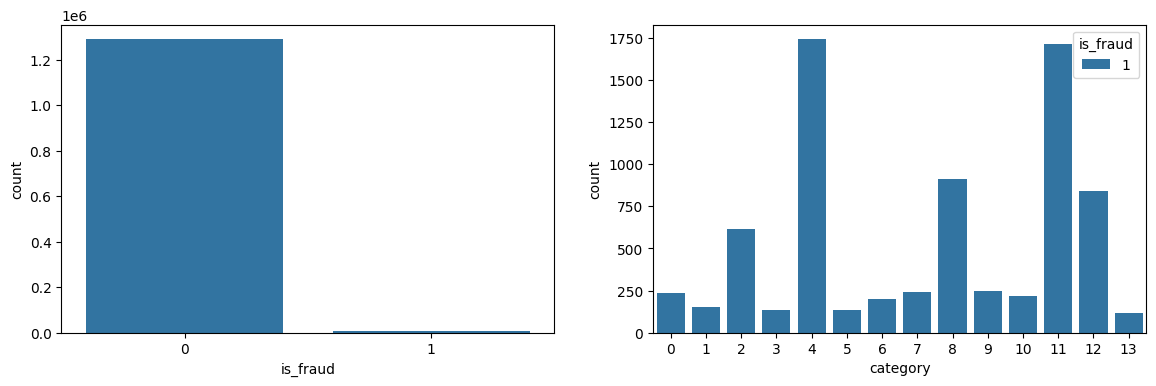

In [6]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
sns.countplot(x='is_fraud', data=train_df)

plt.subplot(1, 2, 2)
sns.countplot(x='category', hue='is_fraud', data=train_df[train_df['is_fraud'] == 1])

plt.show()

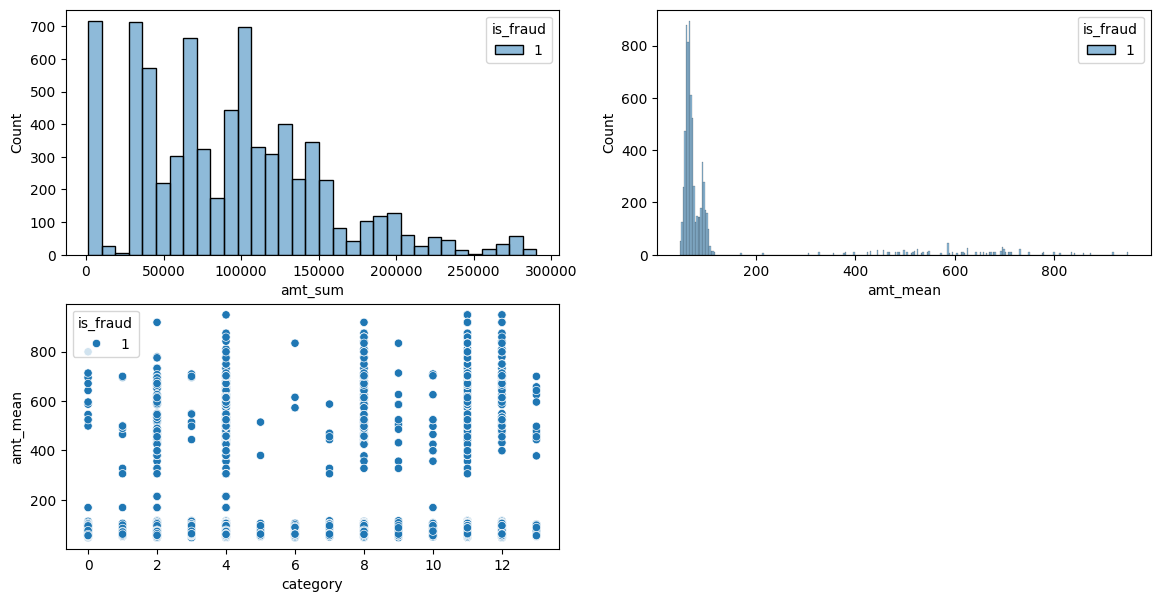

In [7]:
plt.figure(figsize=(14, 7))
plt.subplot(2, 2, 1)
sns.histplot(x='amt_sum', hue='is_fraud', data=train_df[train_df['is_fraud'] == 1])
plt.subplot(2, 2, 2)
sns.histplot(x='amt_mean', hue='is_fraud', data=train_df[train_df['is_fraud'] == 1])
plt.subplot(2, 2, 3)
sns.scatterplot(x='category', y='amt_mean', hue='is_fraud', data=train_df[train_df['is_fraud'] == 1])
plt.show()

## Training

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBRFClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix

import joblib

In [29]:
X = train_df.drop(['is_fraud'], axis=1)
y = train_df['is_fraud']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
def train(clf, name):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_val)

  acc = accuracy_score(y_val, y_pred)
  f1 = f1_score(y_val, y_pred)
  roc_auc = roc_auc_score(y_val, y_pred)
  print(name)
  print(f'Accuracy: {acc}')
  print(f'ROC AUC: {roc_auc}')

  return clf

In [36]:
params = {
    'max_depth': [int(x) for x in np.linspace(10, 50, num = 5)],
    'n_estimators': [int(x) for x in np.linspace(10, 30, num = 5)],
}


clf = GridSearchCV(XGBRFClassifier(), params)

In [35]:
model = train(clf, 'XGBoost')

XGBoost
Accuracy: 0.9971735400158097
F1 Score: 0.7578460521968946
ROC AUC: 0.8766044565309479


## Evaluation

In [37]:
test_df = load_and_preprocess("fraudTest.csv")
test_df.head()

,cc_num,category,amt,lat,long,merch_lat,merch_long,is_fraud,age,cc_num_count,amt_sum,amt_mean,amt_median,amt_std
0,2291163933867244,10,2.86,33.965900,-80.935501,33.986389,-81.200714,0,52,640,39611.56,61.893062,44.23,158.690646
1,3573030041201292,10,29.84,40.320702,-110.435997,39.450497,-109.960434,0,30,837,44860.29,53.596523,35.59,102.395948
2,3598215285024754,5,41.28,40.672901,-73.536499,40.495811,-74.196114,0,50,1073,89116.74,83.053812,54.29,103.740968
3,3591919803438423,9,60.05,28.569700,-80.819099,28.812399,-80.883064,0,33,663,39254.59,59.207526,39.68,108.530732
4,3526826139003047,13,3.19,44.252899,-85.016998,44.959148,-85.884735,0,65,891,49249.58,55.274501,37.67,76.159193


In [38]:
X_test = test_df.drop(['is_fraud'], axis=1)
y_test = test_df['is_fraud']

In [47]:

model.predict(X_test)

y_pred = model.predict(X_test)

print(f"Accuracy: {model.score(X_test, y_test)}")
print(f"ROC AUC: { roc_auc_score(y_test, y_pred)}")

Accuracy: 0.852292255618397
ROC AUC: 0.8274084244241802
